### 0. Imports and setup

In [71]:
from src.dataset import Colored3DMNIST, DataLoader
from torchvision import transforms, datasets
from IPython.display import clear_output
from matplotlib.colors import to_hex
from src.nn import UNet, ResNet_D
from src.plot import plot_img2
from pathlib import Path
from tqdm import tqdm


import torch.nn.functional as F
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import src.data as data
import torch.nn as nn
import numpy as np
import torchvision
import torch
import gc

ImportError: cannot import name 'plot_img2' from 'src.plot' (/home/polosatik/ML_Project/src/plot.py)

In [28]:
if torch.cuda.is_available():
    torch.cuda.set_device(f"cuda:0")
torch.manual_seed(42)
np.random.seed(42)

### 1. Getting the data ready

In [45]:
BATCH_SIZE = 16

def random_color(im):
    hue = np.random.choice([60, 120, 240, 280])
    d = (im *(hue%60)/60)
    im_min, im_inc, im_dec = torch.zeros_like(im), d, im - d
    c_im = torch.zeros((3, im.shape[1], im.shape[2]))
    H = round(hue/60) % 6    
    cmap = [[0, 3, 2], [2, 0, 3], [1, 0, 3], [1, 2, 0], [3, 1, 0], [0, 1, 2]]
    return torch.cat((im, im_min, im_dec, im_inc), dim=0)[cmap[H]]

def Add_dimension(im):
    img_3D = torch.zeros(im.shape[0], im.shape[1], im.shape[2], 16)
    for i in range(im.shape[1]):
      if i < 5 or i > 10:
        img_3D[:, :, :, i] = torch.zeros_like(im)
      else:
        img_3D[:, :, :, i] = im
    return img_3D 

def binarize(im):
    return (im > im.max() / 2).to(im.dtype)

TRANSFORM_3D = transforms.Compose([
    # transforms.Resize(16),
    transforms.ToTensor(),
    # binarize,
    # random_color,
    # Add_dimension,
])

# Load train datasets
# mnist_train_a = datasets.MNIST(root='./data', train=True, download=True, transform=TRANSFORM_3D)

x_train_a = np.load(file='./data/x_train_a.npy')
mnist_train_a = Colored3DMNIST(x_train_a)

# indices = mnist_train_a.targets == 3
# mnist_train_a.data, mnist_train_a.targets = mnist_train_a.data[indices], mnist_train_a.targets[indices]

mnist_loader_a = torch.utils.data.DataLoader(mnist_train_a, batch_size=BATCH_SIZE, shuffle=True)


# mnist_train_b = datasets.MNIST(root='./data', train=True, download=True, transform=TRANSFORM_3D)
x_train_b = np.load(file='./data/x_train_b.npy')
mnist_train_b = Colored3DMNIST(x_train_a)

# indices = mnist_train_b.targets == 5
# mnist_train_b.data, mnist_train_b.targets = mnist_train_b.data[indices], mnist_train_b.targets[indices]

mnist_loader_b = torch.utils.data.DataLoader(mnist_train_b, batch_size=BATCH_SIZE, shuffle=True)


# mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=TRANSFORM_3D)
x_test = np.load(file='./data/x_test.npy')
mnist_test = Colored3DMNIST(x_test)

# indices = mnist_test.targets == 3
# mnist_test.data, mnist_test.targets = mnist_test.data[indices], mnist_test.targets[indices]

mnist_loader_test = torch.utils.data.DataLoader(mnist_test, batch_size=BATCH_SIZE, shuffle=True)

Let's plot a number:

In [46]:
next(iter(mnist_loader_a)).shape

torch.Size([16, 1, 16, 16, 16])

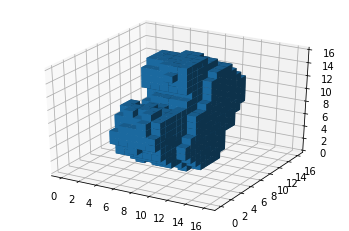

In [47]:
def plot_img(img):
    fig = plt.figure()
    ax = plt.axes(projection="3d")
    
    ax.voxels(img[0])
    plt.show()

plot_img(next(iter(mnist_loader_test))[0])

### 3. Preparation for the training

In [48]:
# Taken from https://github.com/iamalexkorotin/NeuralOptimalTransport/blob/main/src/tools.py
def weights_init_D(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
    elif classname.find('BatchNorm') != -1:
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
        
def weights_init_mlp(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')

In [44]:
f = ResNet_D(16, nc=1).cuda()
f.apply(weights_init_D)

T = UNet(1, 1).cuda()

In [54]:
iter_train_a = iter(mnist_loader_a)
iter_train_b = iter(mnist_loader_b)
iter_test = iter(mnist_loader_test)

def sample_train_a():
    global mnist_loader_a, iter_train_a
    try:
        return next(iter_train_a)
    except StopIteration:
        iter_train_a = iter(mnist_loader_a)
        return next(iter_train_a)

def sample_train_b():
    global mnist_loader_b, iter_train_b
    try:
        return next(iter_train_b)
    except StopIteration:
        iter_train_b = iter(mnist_loader_b)
        return next(iter_train_b)

def sample_test():
    global mnist_loader_test, iter_test
    try:
        return next(iter_test)
    except StopIteration:
        iter_test = iter(mnist_loader_test)
        return next(iter_test)

In [50]:
T_opt = torch.optim.Adam(T.parameters(), lr=1e-5, weight_decay=1e-10)
f_opt = torch.optim.Adam(f.parameters(), lr=1e-4, weight_decay=1e-10)

### 4. Training loop

In [55]:
def sq_cost(X, Y):
  return (X-Y).square().flatten(start_dim=1).mean(dim=1)

In [60]:
device="cuda:0"

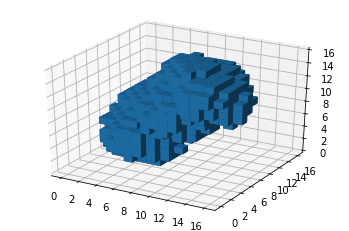

  0%|          | 0/5001 [00:00<?, ?it/s]/home/polosatik/.local/lib/python3.8/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


T_loss: 0.14806179702281952;  f_loss: 0.000979053322225809


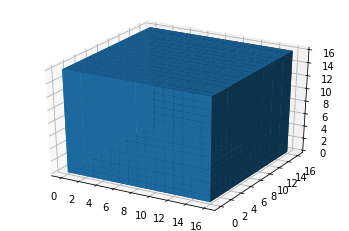

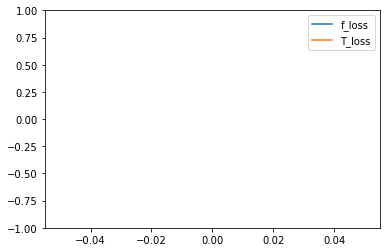

  2%|▏         | 100/5001 [00:56<44:02,  1.85it/s]

T_loss: -0.040157876908779144;  f_loss: -0.0003892481327056885


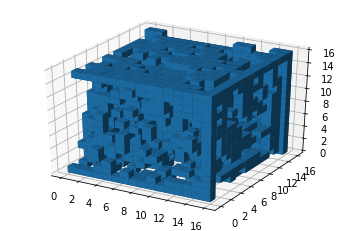

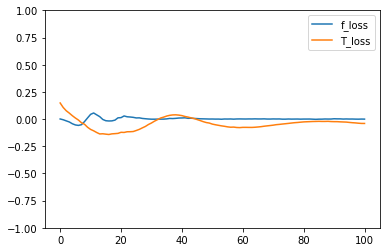

  4%|▍         | 200/5001 [01:52<42:59,  1.86it/s]  

T_loss: -0.014490094967186451;  f_loss: -0.0009563658386468887


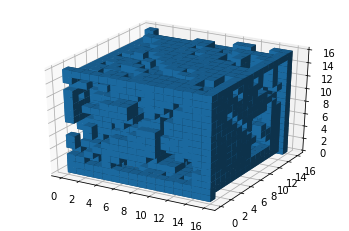

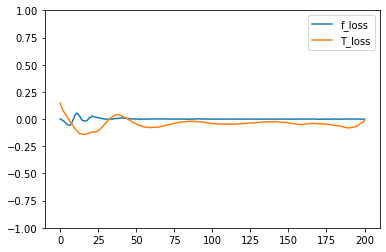

  6%|▌         | 300/5001 [02:48<41:46,  1.88it/s]  

T_loss: -0.047921180725097656;  f_loss: -0.0002094656229019165


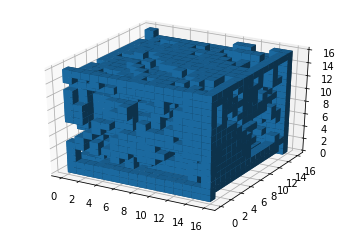

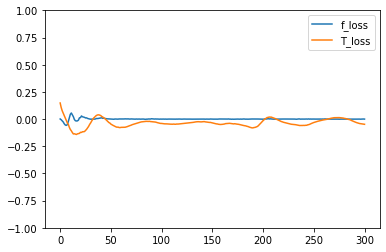

  8%|▊         | 400/5001 [03:44<41:21,  1.85it/s]  

T_loss: -0.010997993871569633;  f_loss: -0.0001162039116024971


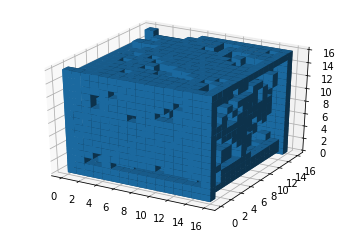

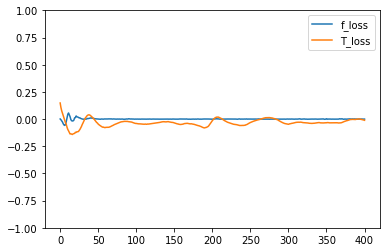

 10%|▉         | 500/5001 [04:40<40:14,  1.86it/s]  

T_loss: -0.051750268787145615;  f_loss: -4.922226071357727e-05


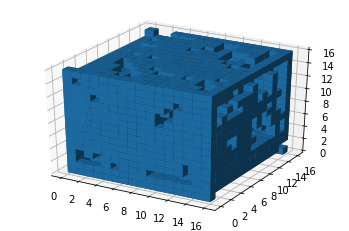

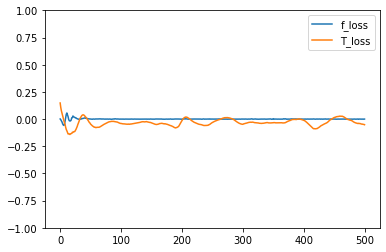

 12%|█▏        | 600/5001 [05:36<39:11,  1.87it/s]  

T_loss: -0.006059332750737667;  f_loss: 0.00037644803524017334


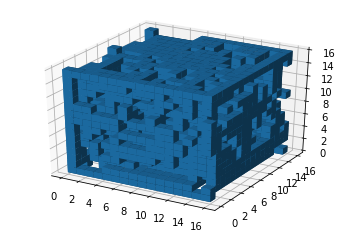

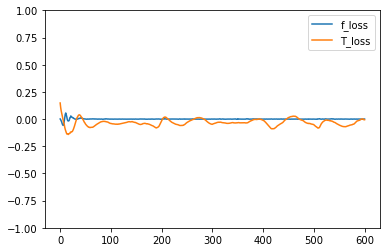

 14%|█▍        | 700/5001 [06:32<38:39,  1.85it/s]  

T_loss: -0.034250408411026;  f_loss: -0.001991923898458481


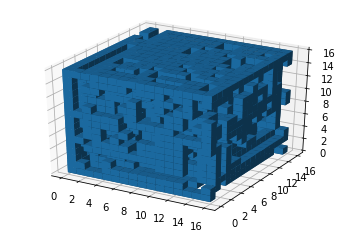

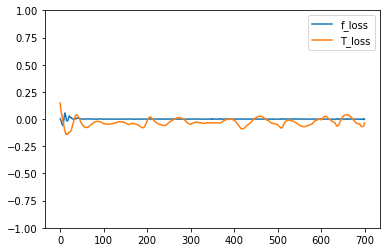

 16%|█▌        | 800/5001 [07:28<37:42,  1.86it/s]  

T_loss: -0.03924886882305145;  f_loss: 0.00021743029356002808


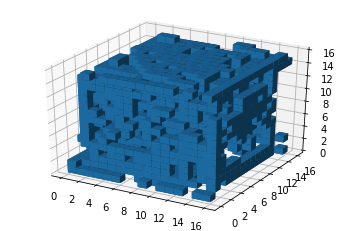

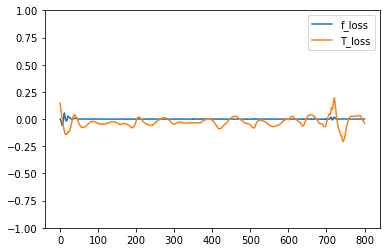

 18%|█▊        | 900/5001 [08:23<36:35,  1.87it/s]  

T_loss: -0.10046437382698059;  f_loss: 0.00016765296459197998


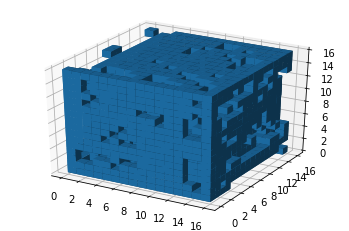

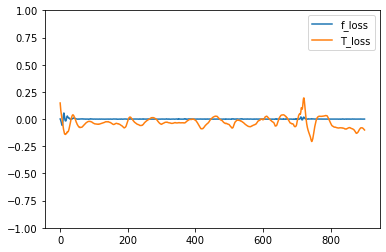

 20%|█▉        | 1000/5001 [09:20<35:59,  1.85it/s] 

T_loss: -0.08070407807826996;  f_loss: 0.0002491995692253113


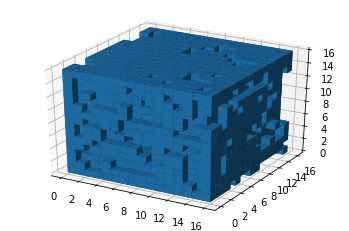

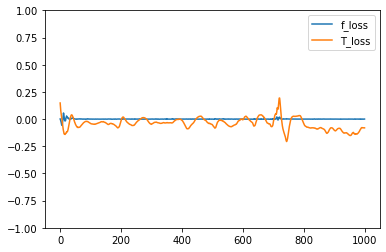

 22%|██▏       | 1100/5001 [10:16<35:03,  1.85it/s]  

T_loss: -0.07541628926992416;  f_loss: 0.0001452416181564331


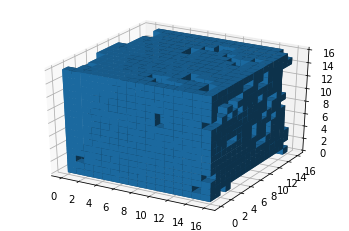

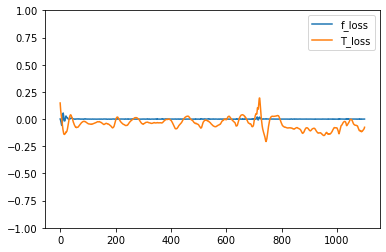

 24%|██▍       | 1200/5001 [11:12<33:57,  1.87it/s]  

T_loss: -0.024575941264629364;  f_loss: 0.004366274923086166


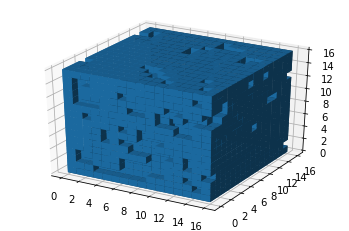

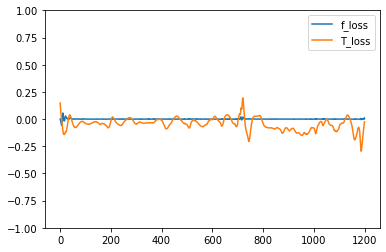

 26%|██▌       | 1300/5001 [12:08<33:21,  1.85it/s]  

T_loss: -0.01725969836115837;  f_loss: 1.977197825908661e-05


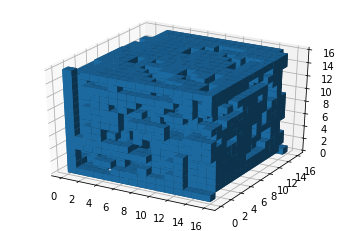

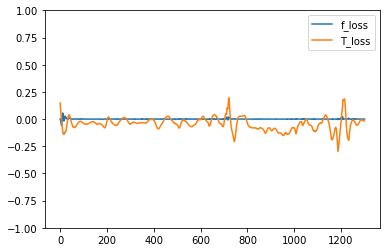

 28%|██▊       | 1400/5001 [13:04<32:21,  1.85it/s]  

T_loss: -0.11308296024799347;  f_loss: 0.0007681846618652344


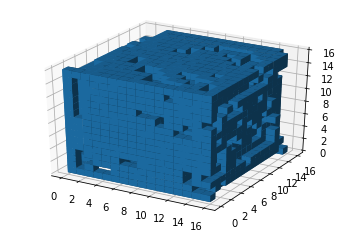

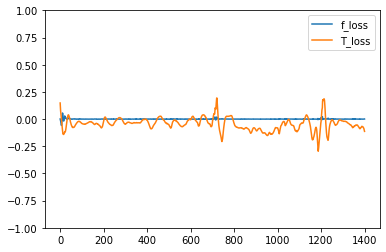

 30%|██▉       | 1500/5001 [14:00<31:21,  1.86it/s]  

T_loss: -0.04000210762023926;  f_loss: 0.00036270543932914734


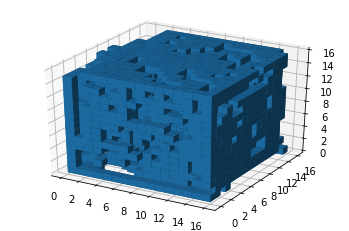

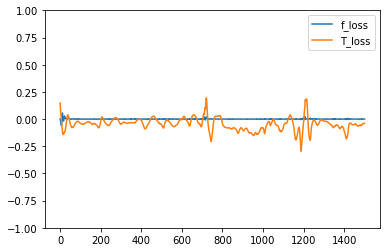

 32%|███▏      | 1600/5001 [14:56<30:40,  1.85it/s]  

T_loss: -0.05790310725569725;  f_loss: -0.0007142685353755951


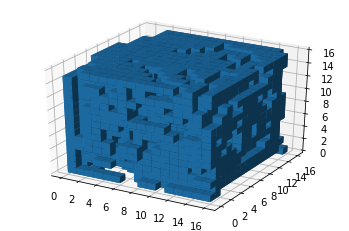

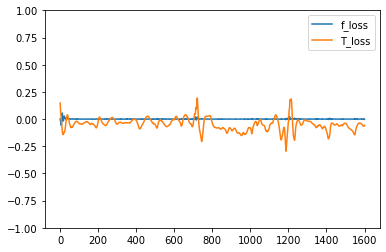

 34%|███▍      | 1700/5001 [15:52<29:42,  1.85it/s]  

T_loss: 0.01776823401451111;  f_loss: 0.0002814941108226776


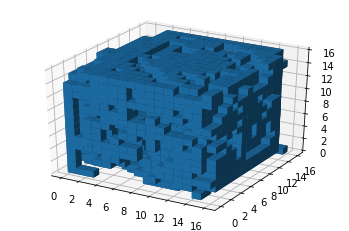

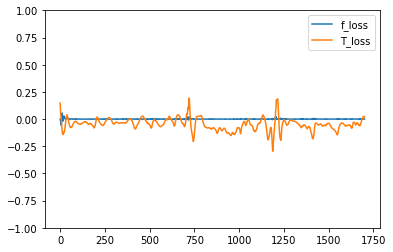

 36%|███▌      | 1800/5001 [16:48<28:36,  1.86it/s]  

T_loss: 0.0338735356926918;  f_loss: 0.0007683336734771729


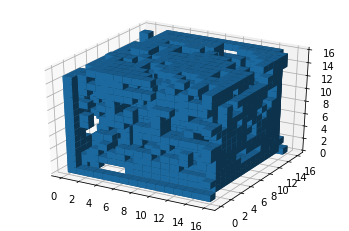

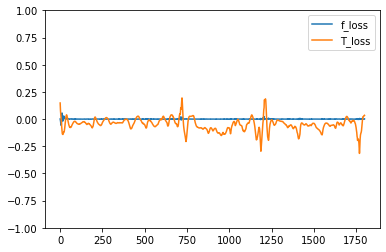

 38%|███▊      | 1900/5001 [17:44<27:56,  1.85it/s]  

T_loss: 0.03807453066110611;  f_loss: 0.00016349181532859802


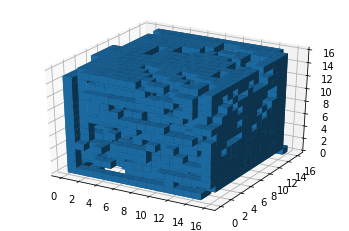

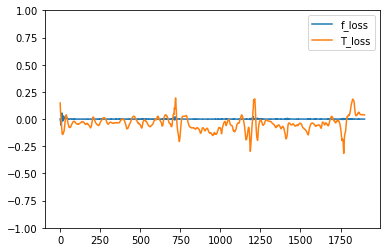

 40%|███▉      | 2000/5001 [18:40<27:00,  1.85it/s]  

T_loss: -0.006515426095575094;  f_loss: -0.0009137270972132683


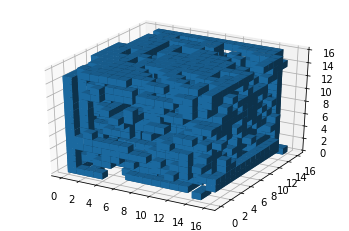

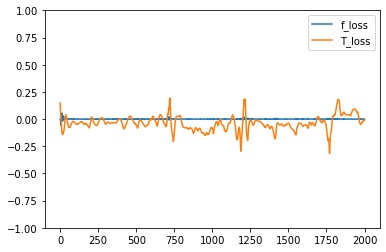

 42%|████▏     | 2100/5001 [19:36<26:02,  1.86it/s]

T_loss: -0.1175994724035263;  f_loss: -0.0011128336191177368


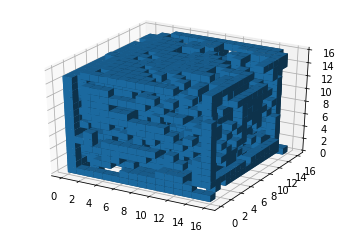

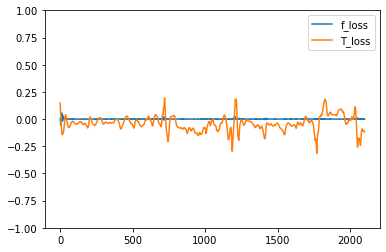

 44%|████▍     | 2200/5001 [20:32<25:13,  1.85it/s]

T_loss: -0.15452322363853455;  f_loss: 0.00035659968852996826


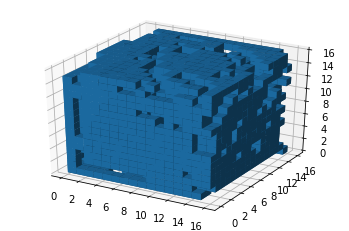

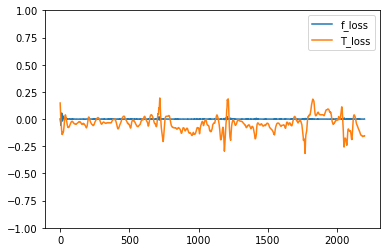

 46%|████▌     | 2300/5001 [21:29<24:19,  1.85it/s]

T_loss: 0.037096764892339706;  f_loss: -0.000306788831949234


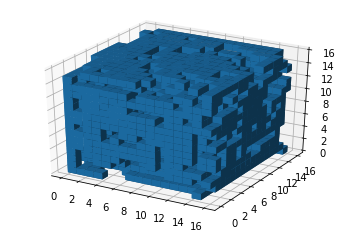

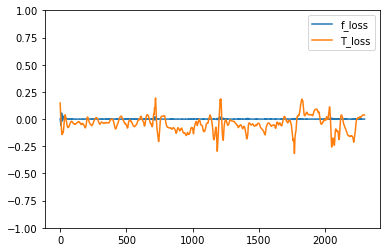

 48%|████▊     | 2400/5001 [22:25<23:22,  1.85it/s]

T_loss: -0.024686560034751892;  f_loss: -0.00010415352880954742


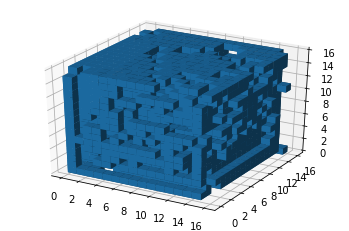

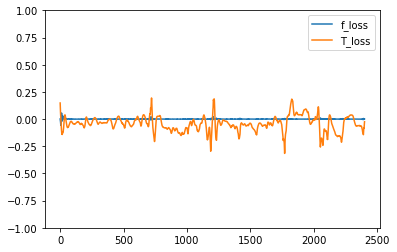

 50%|████▉     | 2500/5001 [23:21<22:34,  1.85it/s]

T_loss: -0.08987122774124146;  f_loss: -7.942318916320801e-05


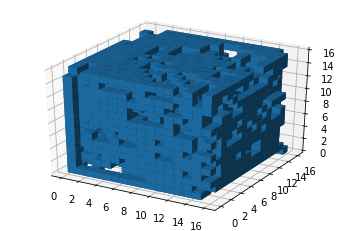

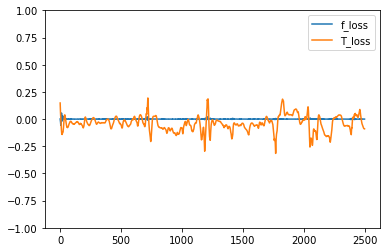

 52%|█████▏    | 2600/5001 [24:17<21:39,  1.85it/s]

T_loss: 0.09286414086818695;  f_loss: 0.00041284412145614624


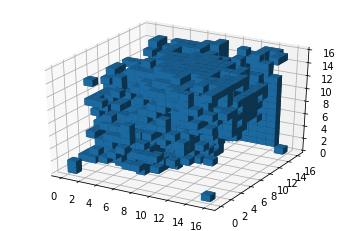

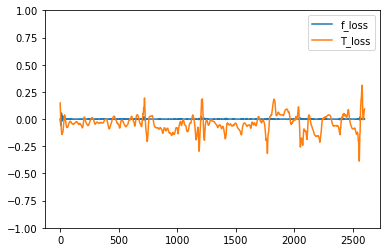

 54%|█████▍    | 2700/5001 [25:13<20:41,  1.85it/s]

T_loss: 0.08257156610488892;  f_loss: -0.0005590394139289856


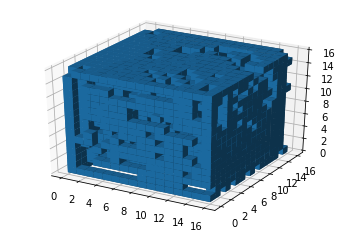

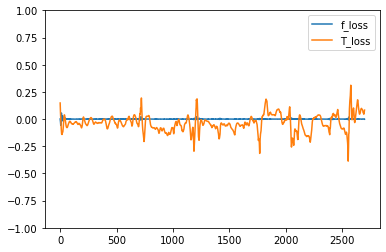

 56%|█████▌    | 2800/5001 [26:09<19:35,  1.87it/s]

T_loss: 0.15836578607559204;  f_loss: -5.669891834259033e-05


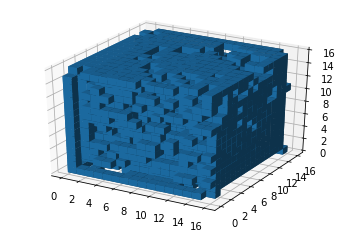

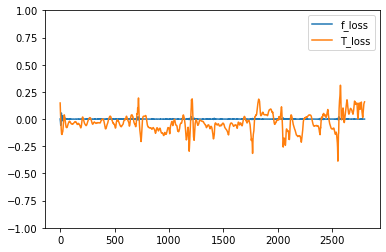

 58%|█████▊    | 2900/5001 [27:05<18:57,  1.85it/s]

T_loss: 0.22330670058727264;  f_loss: 0.0002788156270980835


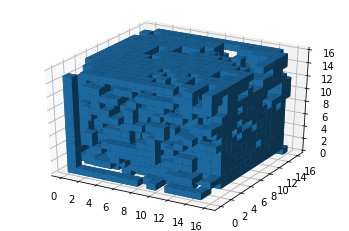

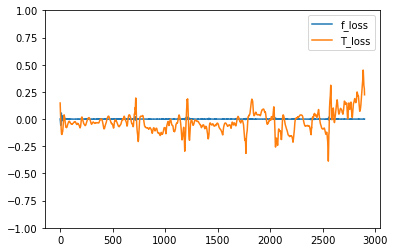

 60%|█████▉    | 3000/5001 [28:01<18:00,  1.85it/s]

T_loss: 0.25681766867637634;  f_loss: -8.597970008850098e-05


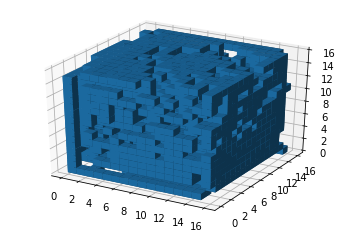

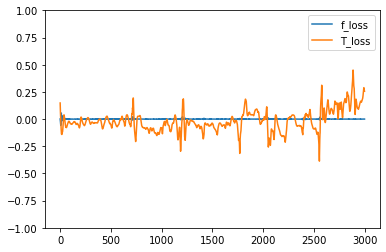

 62%|██████▏   | 3100/5001 [28:58<16:47,  1.89it/s]

T_loss: 0.34952041506767273;  f_loss: -0.0007326602935791016


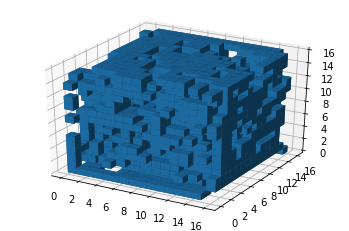

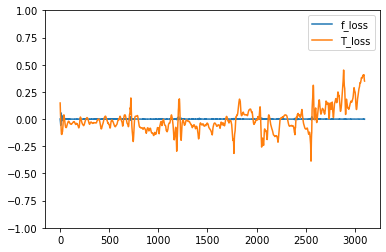

 64%|██████▍   | 3200/5001 [29:54<16:14,  1.85it/s]

T_loss: 0.003413204103708267;  f_loss: -0.0005861972458660603


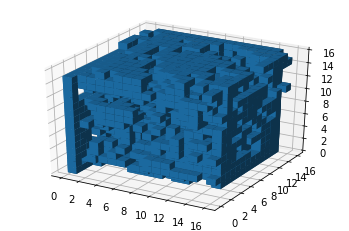

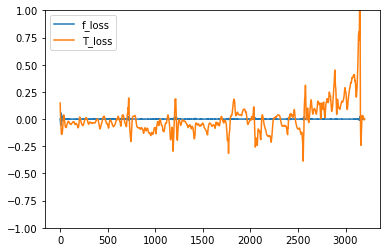

 66%|██████▌   | 3300/5001 [30:50<15:19,  1.85it/s]

T_loss: 0.07323383539915085;  f_loss: -0.0005400627851486206


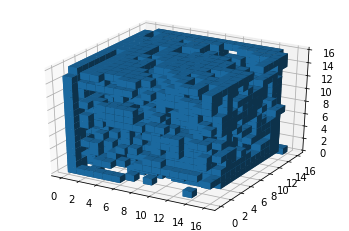

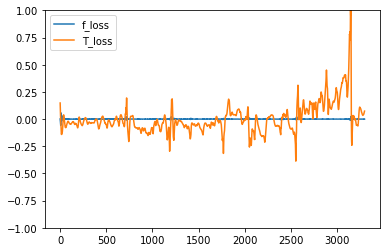

 68%|██████▊   | 3400/5001 [31:46<14:16,  1.87it/s]

T_loss: 0.10996236652135849;  f_loss: -9.88692045211792e-06


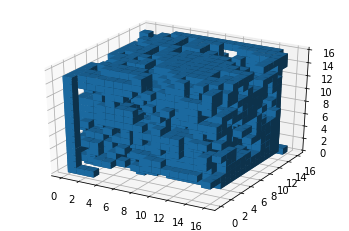

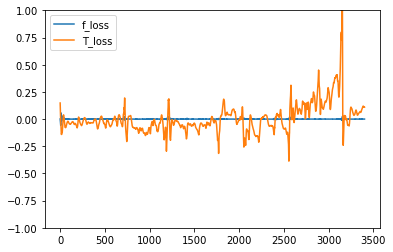

 70%|██████▉   | 3500/5001 [32:42<13:31,  1.85it/s]

T_loss: 0.09892702102661133;  f_loss: -0.00028540194034576416


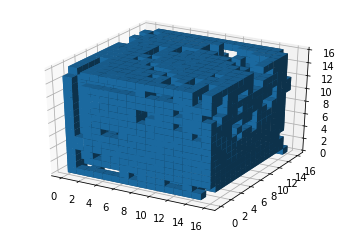

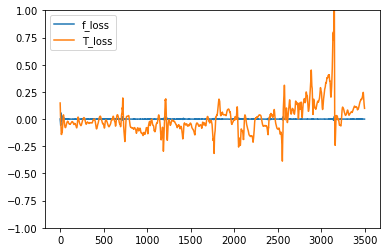

 72%|███████▏  | 3600/5001 [33:38<12:34,  1.86it/s]

T_loss: 0.1546209752559662;  f_loss: -0.0003029555082321167


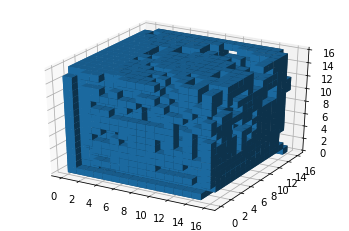

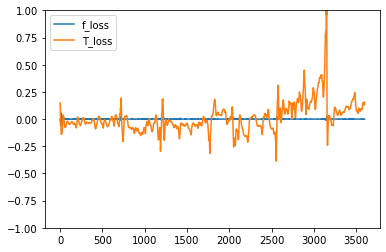

 74%|███████▍  | 3700/5001 [34:34<11:39,  1.86it/s]

T_loss: -0.007523257751017809;  f_loss: 0.00017031189054250717


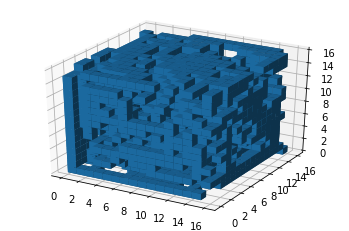

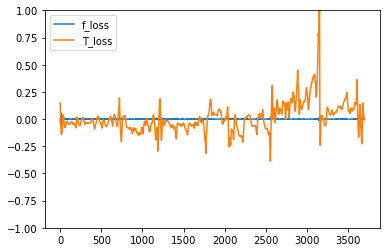

 76%|███████▌  | 3800/5001 [35:30<10:50,  1.85it/s]

T_loss: 0.10319109261035919;  f_loss: -0.0003208070993423462


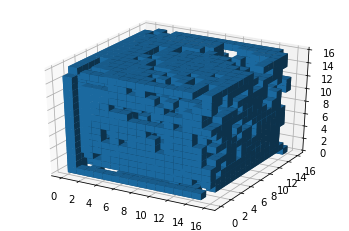

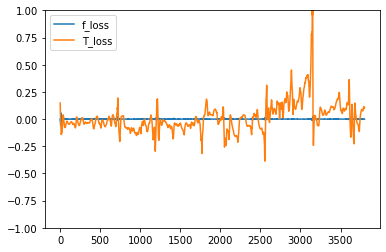

 78%|███████▊  | 3900/5001 [36:26<09:59,  1.84it/s]

T_loss: -123.9864730834961;  f_loss: -193.3706512451172


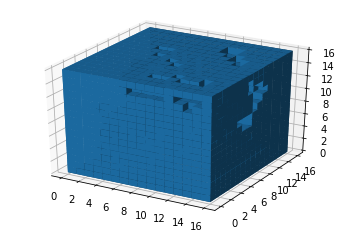

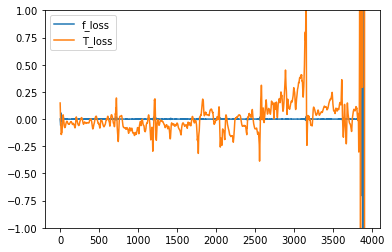

 80%|███████▉  | 4000/5001 [37:23<08:56,  1.86it/s]

T_loss: 2.7471864223480225;  f_loss: -0.0709524154663086


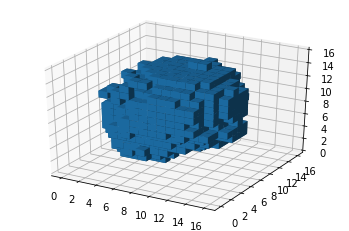

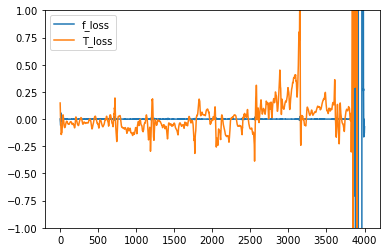

 82%|████████▏ | 4100/5001 [38:18<08:08,  1.84it/s]

T_loss: 1.1381782293319702;  f_loss: -0.05588674545288086


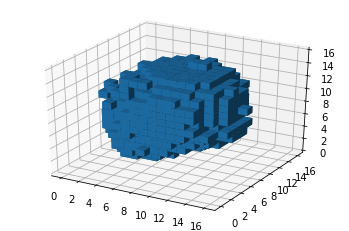

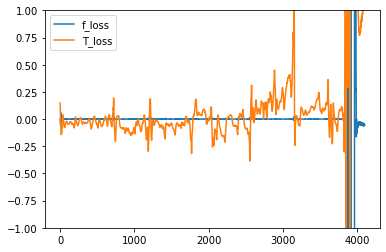

 84%|████████▍ | 4200/5001 [39:12<07:13,  1.85it/s]

T_loss: 1.7548259496688843;  f_loss: -0.07533276081085205


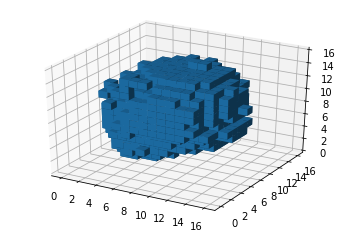

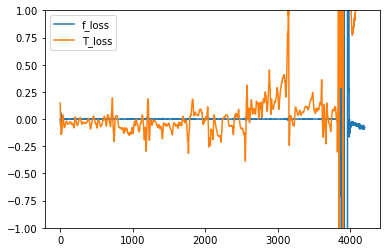

 86%|████████▌ | 4300/5001 [40:07<06:17,  1.86it/s]

T_loss: 2.467008352279663;  f_loss: -0.09636354446411133


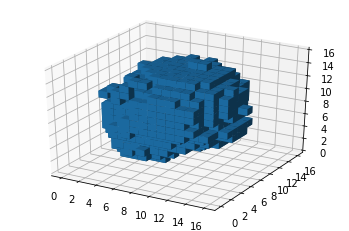

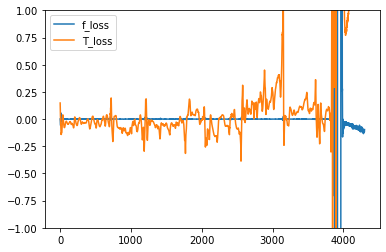

 88%|████████▊ | 4400/5001 [41:03<05:25,  1.85it/s]

T_loss: 3.246241569519043;  f_loss: -0.15146827697753906


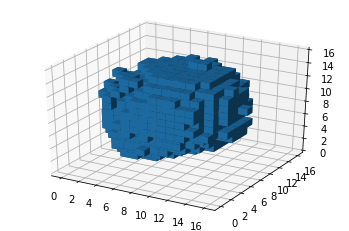

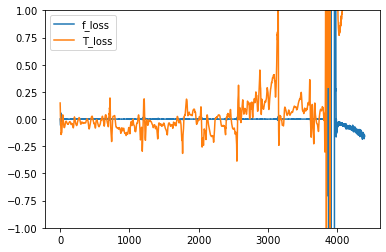

 90%|████████▉ | 4500/5001 [41:57<04:30,  1.85it/s]

T_loss: 4.360820770263672;  f_loss: -0.24135923385620117


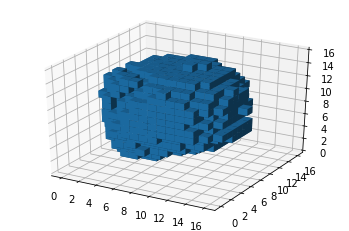

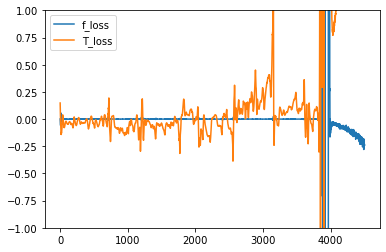

 92%|█████████▏| 4600/5001 [42:52<03:36,  1.85it/s]

T_loss: 5.98667573928833;  f_loss: -0.31365108489990234


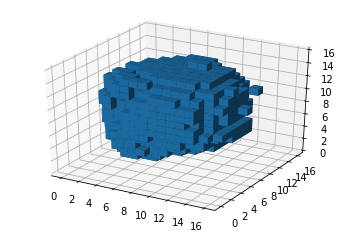

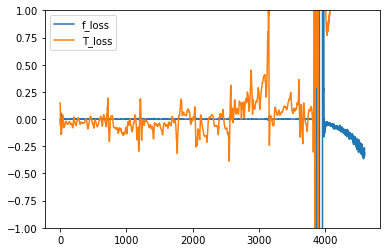

 94%|█████████▍| 4700/5001 [43:48<02:43,  1.84it/s]

T_loss: 8.775001525878906;  f_loss: -0.5674953460693359


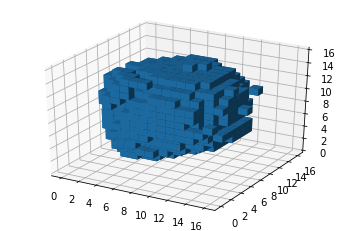

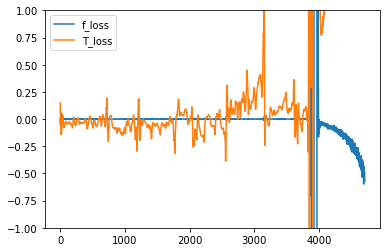

 96%|█████████▌| 4800/5001 [44:43<01:49,  1.84it/s]

T_loss: 14.029239654541016;  f_loss: -0.9948844909667969


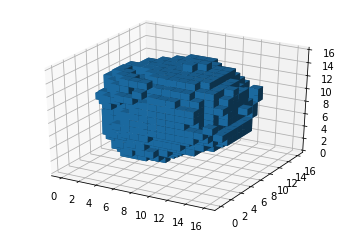

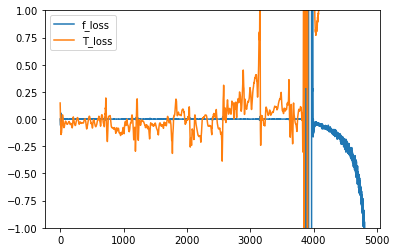

 98%|█████████▊| 4900/5001 [45:38<00:54,  1.86it/s]

T_loss: 32.17801284790039;  f_loss: -3.4652328491210938


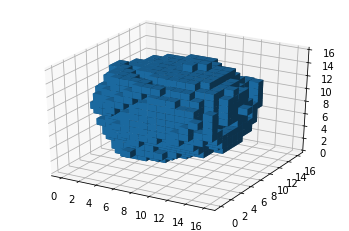

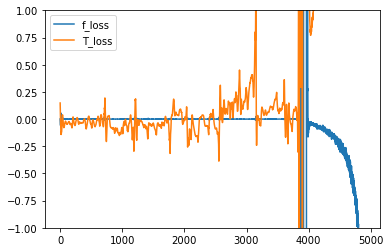

100%|█████████▉| 5000/5001 [46:33<00:00,  1.84it/s]

T_loss: -0.618815541267395;  f_loss: 0.07014518976211548


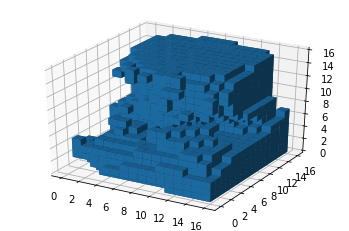

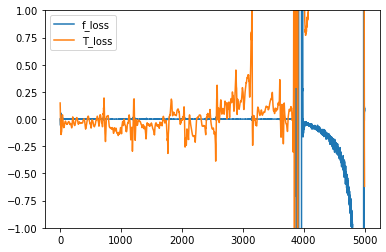

100%|██████████| 5001/5001 [46:35<00:00,  1.79it/s]


In [62]:
test_sample = sample_test().to(device=device, dtype=torch.float)
plot_img(test_sample[0].cpu())
T_losses = []
f_losses = []

for step in tqdm(range(5001)):
    # clear_output(wait=True)

    # Training T, freezing f
    T.train(True)
    f.eval()
    
    for i in range(5):
        X = sample_train_a().to(device=device, dtype=torch.float)

        T_X = T(X)
        T_loss = sq_cost(X, T_X).mean() - f(T_X).mean()
        T_opt.zero_grad()
        T_loss.backward()
        T_opt.step()
    
    T_losses.append(T_loss.cpu().detach().numpy())

    # Training f, freezing T
    f.train(True)
    T.eval()

    X = sample_train_a().to(device=device, dtype=torch.float)
    Y = sample_train_b().to(device=device, dtype=torch.float)

    with torch.no_grad():
        T_x = T(X)
    
    f_loss = f(T_x).mean() - f(Y).mean()
    f_opt.zero_grad()
    f_loss.backward()
    f_opt.step()

    f_losses.append(f_loss.cpu().detach().numpy())

    if not step % 100:
        print(f"T_loss: {T_loss}; ", end="")
        print(f" f_loss: {f_loss}")
        T_X = torch.clip(T(test_sample)[0].cpu().detach(), min=0, max=1)
        plot_img(T_X)

        plt.plot(np.arange(len(f_losses)), f_losses, label="f_loss")
        plt.plot(np.arange(len(T_losses)), T_losses, label="T_loss")

        plt.ylim(-1, 1)
        plt.legend()
        plt.show()

    # Save OT map every 1000 steps
    if not step % 1000:
        torch.save(T.state_dict, f"weights/OT_{step}.pt")

    gc.collect()
    torch.cuda.empty_cache()

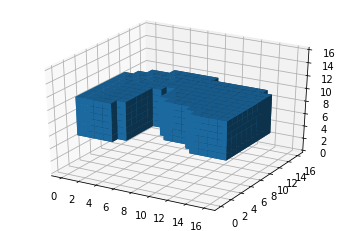

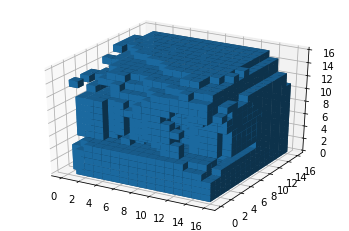

In [69]:
sample_n = 10
plot_img(test_sample[sample_n].cpu())

T_X = torch.clip(T(test_sample)[sample_n].cpu().detach(), min=0, max=1)

plot_img(T_X)

In [72]:
from src.utils import data_config
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import pandas as pd
import numpy as np

def plot_img2(image, plot_only_figure=True):
    for x in range(data_config.x_shape):
        for y in range(data_config.y_shape):
            for z in range(data_config.z_shape):
                # find first voxel and get it's color
                if (image[0, x, y, z] > 0):
                    plot_img_color = np.squeeze(image[:, x, y, z])
                    break
                if (image[1, x, y, z] > 0):
                    plot_img_color = np.squeeze(image[:, x, y, z])
                    break
                if (image[2, x, y, z] > 0):
                    plot_img_color = np.squeeze(image[:, x, y, z])
                    break
    # 0 - red, 1 - yellow and green, 2 - blue
    if plot_img_color[0] == 255:
        color_ind = 0
    elif plot_img_color[1] == 255:
        color_ind = 1
    elif plot_img_color[2] == 255:
        color_ind = 2
    else:
        raise ValueError("Incorrect color encountered.")
        
    plot_img_3d = image[color_ind]
    plot_label = "3"
    color = np.zeros(3)
    plot_data = []
    for x in range(data_config.x_shape):
        for y in range(data_config.y_shape):
            for z in range(data_config.z_shape):
                #val = int(plot_img_3d[x, y, z] * 255)
                isVoxel = (plot_img_3d[x, y, z] > 0)
                if isVoxel:                   
                    color[0] = int(image[0, x, y, z])
                    color[1] = int(image[1, x, y, z])
                    color[2] = int(image[2, x, y, z])
                else:
                    color[0] = 255
                    color[1] = 255
                    color[2] = 255             
                plot_data.append([x, y, z, isVoxel, f'rgb({color[0]}, {color[1]}, {color[2]})'])
    plot_df = pd.DataFrame(plot_data, columns=["x", "y", "z", "isVoxel", "color"])
    if plot_only_figure:
        plot_df = plot_df.loc[plot_df["isVoxel"] == True]

    fig = go.Figure(data=[go.Scatter3d(x=plot_df['x'], y=plot_df['y'], z=plot_df['z'], 
                                       mode='markers',
                                       text=f"current label: {plot_label}",
                                       marker=dict(
                                       color = plot_df["color"],
                                       size=4,       
                                       colorscale='Viridis',
                                       opacity= 0.8 ))])
    fig.show()
    

In [81]:
test_sample = sample_test().to(device=device, dtype=torch.float)


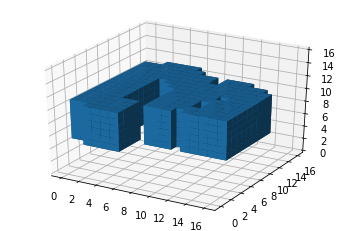

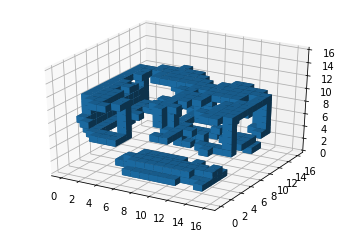

In [82]:
sample_n = 3
plot_img(test_sample[sample_n].cpu())

T_X = torch.clip(T(test_sample)[sample_n].cpu().detach(), min=0, max=1)
T_X[T_X < np.quantile(T_X, 0.91)] = 0
plot_img(T_X)